# Прогнозирование временных рядов бизнес-драйверов.

#### Обязательное условие от заказчика:
**на формирование прогноза на один временной ряд должно отводиться не более 4-х минут (240 секунд).** 
#### Цель:
**прогнозирование временного ряда на следующий календарный месяц, начиная с последней даты, представленной в наборах.**

Импортируем все необходимые пакеты для создания модели ML для предсказания Time Series

In [396]:
import pandas as pd                         # библиотека для анализа и обработки табличных данных
import numpy as np                          # библиотека для матричных вычислений
import time

# пакеты для визуализации данных, графическом отображении факторов и их зависимостей
import matplotlib.pyplot as plt                              
%matplotlib inline
import seaborn as sns                                        
import plotly.graph_objects as go                          # интерактивная визуализации данных 
import plotly.express as px
from plotly.subplots import make_subplots                  # для создания многоуровневых графиков

# библиотека статистических тестов, инструментов оценки различных моделей и исследования данных
import statsmodels.api as sm                                     
from statsmodels.tsa.seasonal import seasonal_decompose    # инструмент декомпозиции временного ряда
from statsmodels.tsa.stattools import adfuller             # тест Дики-Фулера на стационарность временного ряда

from sklearn.metrics import mean_squared_error as mse       # метрика оценки качества модели - среднеквадратичная ошибка
from sklearn.metrics import mean_absolute_percentage_error as mape

# нейронная сеть для прогнозирования временных рядов (потомок Prophet от facebook)
#!pip install neuralprophet
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, set_log_level   # воспроизводимость одинакового результата и установка уровня логирования для обучения модели

import warnings
warnings.filterwarnings('ignore')

In [397]:
# загружаем данные
df1 = pd.read_csv('data/data1.csv')
df2 = pd.read_csv('data/data2.csv')
df3 = pd.read_csv('data/data3.csv')
df4 = pd.read_csv('data/data4.csv')
df5 = pd.read_csv('data/data5.csv')

### 1. Подготовка данных
Посмотрим общую информацию о типах данных и пропуски

In [398]:
dfs = [df1, df2, df3, df4, df5] # список переменных-датасетов

for i, df in enumerate(dfs):
    print(f'Датасет номер {i+1}: ')
    print(df.info())
    print('\n')

Датасет номер 1: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   974 non-null    float64
 1   date    974 non-null    object 
dtypes: float64(1), object(1)
memory usage: 15.3+ KB
None


Датасет номер 2: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   973 non-null    float64
 1   date    974 non-null    object 
dtypes: float64(1), object(1)
memory usage: 15.3+ KB
None


Датасет номер 3: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   968 non-null    float64
 1   date    974 non-null    object 
dtypes: float64(1), object(1)
memory usage: 15.3+ KB
None


Датасет но

Второй и третий датасет содержат пропуски. Прежде всего займемся ими.

In [399]:
# найдем пропуск во втором датасете
null = df2[df2['value'].isna()==True]
null

,value,date
425,NaN,2023-03-02


In [400]:
# используем интерполяцию для заполнения найденного пропуска
df2['value'] = df2['value'].interpolate(method='linear')
df2.value.loc[424:426]

424    153.0
425    150.5
426    148.0
Name: value, dtype: float64

In [401]:
# посмотрим на пропуски в третьем наборе данных
null = df3[df3['value'].isna()==True]
null

,value,date
673,NaN,2023-11-05
674,NaN,2023-11-06
682,NaN,2023-11-14
767,NaN,2024-02-07
952,NaN,2024-08-10
953,NaN,2024-08-11


In [402]:
# так как пропусков немного и они разбросаны в ряду, то мы также можем их интерполировать
df3['value'] = df3['value'].interpolate(method='linear')
df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   974 non-null    float64
 1   date    974 non-null    object 
dtypes: float64(1), object(1)
memory usage: 15.3+ KB


### 2. EDA
Изучим данные с помощью инструментов визуализации, чтобы для начала наглядно определить закономерности.

**2.1 Выделим из даты три временных признака: год, месяц, неделя**

In [403]:
# преобразовываем дату в нужный формат datetime во всех датасетах
def put_datetime(df):
    df['date'] = pd.to_datetime(df.date)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month_name(locale='English')
    df['day_of_week'] = df['date'].dt.day_name()
    # теперь мы можем установить дату в качестве индекса для создания последовательности
    return df.set_index('date', drop=True, inplace=True)

put_datetime(df1)
put_datetime(df2)
put_datetime(df3)
put_datetime(df4)
put_datetime(df5)

**2.2 Динамика данных во времени**

In [404]:
# функция для отображения временного ряда исходных данных, принимает временной ряд и название для графика
def visualise_serie(df, title):
    fig = px.line(df, x=df.index, y='value', height=300, width=1000, title=title, color_discrete_sequence=['green'])
    fig.update_layout(
        title={'x':0.5,'xanchor': 'center', 'yanchor': 'top'},  # расположение графика
        autosize=False, margin=dict(t=30, b=20, l=20, r=10),    # отступы от плоскости
        template="ggplot2")   
    fig.show()   
    
# применим функцию
for i, df in enumerate(dfs):
    visualise_serie(df, f'Dynamic Data {i+1}')

1. Первый, второй, четвертый с видимыми циклами в своих рядах.
2. Предварительно по третьему набору можно отметить тренд на плавное снижение значений показателя, а также разнообразие резких скачков на всем ряду.
3. Пятый датасет имеет небольшой объем данных и пока сложно определить какие-либо зависимости по графику. 

Посмотрим разницу значений показателей по годам для каждого месяца.

In [405]:
# функция для отображения столбчатой диаграммы показателей по месяцам, функция принимает датасет и название для графика
def visualise_monthly(df,title):
    years = df['year'].unique().tolist() # формируем список лет, которые у нас присутствуют в данных
    # задаем плоскость
    fig = make_subplots(rows=1, cols=len(years), subplot_titles=years)
    for i,year in enumerate(years):
        fig.add_trace(go.Bar(y=df[df.year==year]['month'], x=df[df.year==year]['value'], orientation='h'), row=1, col=i+1)
        fig.update_layout(xaxis=dict(tickmode="array", tickvals=np.arange(0, 120000, 20000)))
    fig.update_layout(
        width=1000, height=350,                                                               
        autosize=False, margin=dict(t=40, b=10, l=10, r=20),
        template="ggplot2", showlegend=False,
        title=title,                    
    )
    fig.show()
# запускаем функцию в цикле
for i, df in enumerate(dfs):
    visualise_monthly(df, f'Dynamic Data {i+1}')

На всех графиках мы наблюдаем цикличность значений по месяцам в году. То есть все наши данные содержат сезонную годовую компоненту.

Посмотрим динамику показателей по дня недели.

In [406]:
# функция для отображения столбчатой диаграммы показателей по дням недели, функция принимает набор данных и название для графика
def visualise_weekly(df,title):
    years = df['year'].unique().tolist() # формируем список лет, которые у нас присутствуют в данных
    # задаем плоскость
    fig = make_subplots(rows=1, cols=len(years), subplot_titles=years)
    for i,year in enumerate(years):
        fig.add_trace(go.Bar(y=df[df.year==year]['day_of_week'], x=df[df.year==year]['value'], orientation='h'), row=1, col=i+1)
    fig.update_layout(
        width=1000, height=200,                                                               
        autosize=False, margin=dict(t=40, b=10, l=10, r=20),
        template="ggplot2", showlegend=False,
        title=title,                    
    )
    fig.show()
# запускаем функцию в цикле
for i, df in enumerate(dfs):
    visualise_weekly(df, f'Dynamic weekly Data {i+1}')

Цикличность мы видим и на ежедневных показателях недели.

### 3. Анализ зависимостей временных рядов
**3.1 Декомпозиция временного ряда**\
Тренд - основная тенденция изменения показателя во времени, цикличность - колебания (периоды подъема и спада) временного ряда относительно тренда (если таковые имеются) и сезонность - периодически повторяющаяся компонента.\
Функция seasonal_decompose из библиотеки statsmodels принимает на вход временной ряд и раскладывает его на трендовую, сезонную и остаточную составляющие. 

Декомпозиция временного ряда 1-го набора


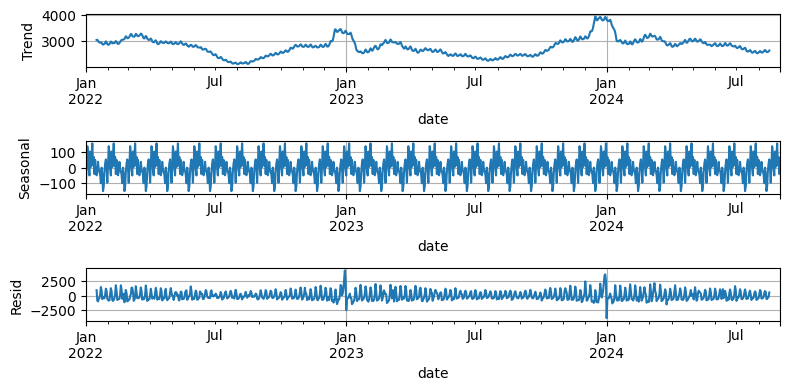

None
Декомпозиция временного ряда 2-го набора


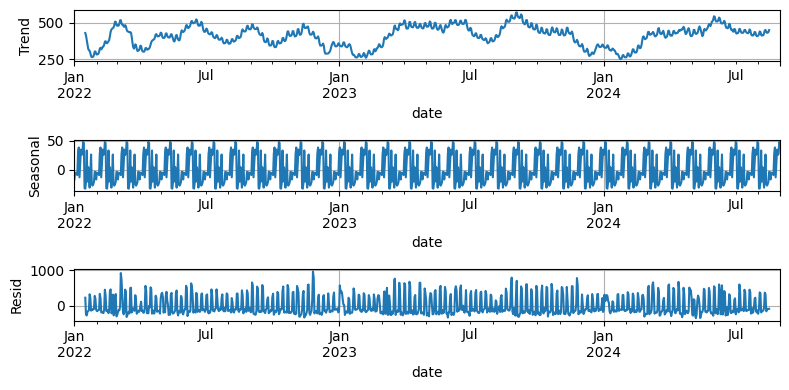

None
Декомпозиция временного ряда 3-го набора


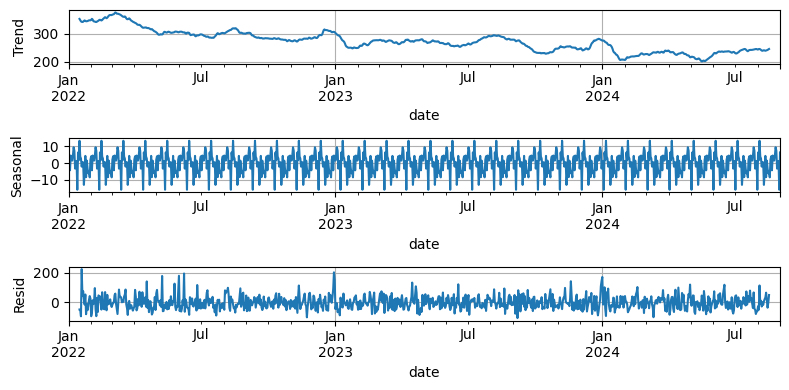

None
Декомпозиция временного ряда 4-го набора


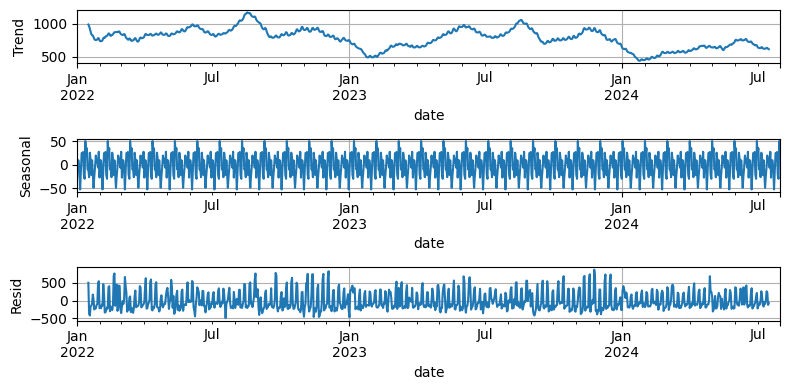

None
Декомпозиция временного ряда 5-го набора


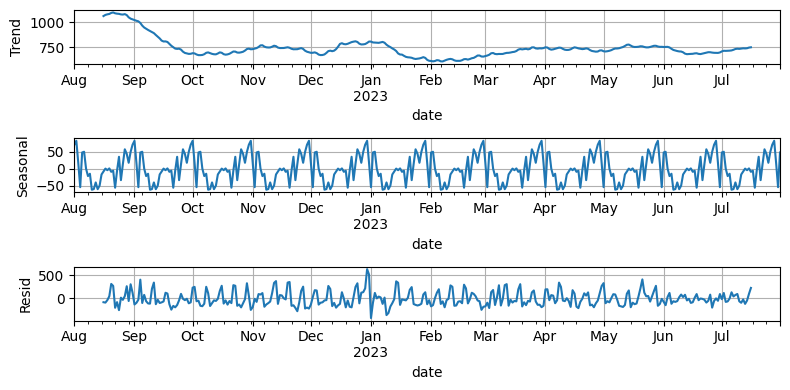

None


In [407]:
# напишем функцию для декомпозиции временных рядов
def decompose(df):
    series = seasonal_decompose(df.value, period=30) # период возьмем 30 дней (~ календарный месяц)
    # отобразим составляющие компоненты на графиках
    fig,ax = plt.subplots(3,1, figsize=(8,4))
    series.trend.plot(ax=ax[0], ylabel='Trend', grid=True)        # тренд
    series.seasonal.plot(ax=ax[1], ylabel='Seasonal', grid=True)  # сезонность
    series.resid.plot(ax=ax[2], ylabel='Resid', grid=True)        # остатки(шум)
    plt.tight_layout()
    plt.show()

# применим функцию к каждому набору
for i,df in enumerate(dfs):
    print(f"Декомпозиция временного ряда {i+1}-го набора")
    print(decompose(df))

Итак, все наборы данных обладают ежегодной сезонностью и еженедельной цикличностью. В последнем 5-м ряду это сложно определить визуально из-за небольшого количества данных.

**3.2 Автокорреляция, частичная корреляция**

Создаем функцию, которая примет на вход наш временной ряд и с помошью специальных инструментов библиотеки statsmodels отобразит статистическую взаимосвязь между последовательностями значений ряда: корреграмма plot_acf (график автокорреляция), частичная автокорреляция plot_pac, QQ-график и распределение остатков.
1) Автокорреляция так и переводится - это корряция временного ряда с самим с собой: насколько значение во временном ряду похоже на предыдущее. Она помогает выявлять тенденции и оценивать влиянее ранее наблюдаемых значений (лагов) на текущее наблюдение. Значения на коррелограмме будут близки к нулю, если данные ряда не зависят от себя в прошлом. Если максимальное значение на коррелограмме находится в лаге 1, то ряд содержит только тренд. Если максимальное значение выражено ненулевым или первым лагом (например, 5), то временной ряд содержит циклическую компоненту с периодом 5. Лаги отображают инерцию зависимости, то есть если все лаги выше доверительного интервала (по умолчанию равен 95%) снижаются постепенно, то более дальные наблюдения оказывают меньший эффект на текущее значение.
2) Частичная автокорреляция описывает только прямую связь между текущим наблюдением и наблюдениями на предыдущем отрезке времени с удалением взаимосвязей между промежуточными наблюдениями. Частичная автокорреляция даёт более «чистую» картину периодических зависимостей, так как исключается влияние автокорреляций с меньшими лагами.
3) QQ график представляет линию главного тренда вокруг прямой идеального нормального распределения для наших данных.\
Если оба конца квантильного графика находятся выше прямой главного тренда, то скорее всего это распределение скошено вправо.\
Если оба конца квантильного графика находится ниже прямой главного тренда, то скорее всего это распределение скошено влево.\
Если точки на графике Q-Q Plot стелятся вдоль прямой, то наши данные неплохо соответствуют теоретическим квантилям, отложенным по горизонтальной оси.\
Равномерное распределение - это S-образная кривая, стелющаяся вдоль линии тренда, бимодальное распределение - это S-образная кривая, пересекающая линию тренда, t-распределение - это зеркально отраженная S-образная кривая.
4) Гистограмма распределения.


In [408]:
# функция для графического отображения зависимости последовательностей временного ряда
# агрументы: временной ряд, координатная плоскость, название графика и лаги(предыдущее значение)
def tsdisplay(X, figsize = (18,8), title = " ", lags = 40):
    fig = plt.figure(figsize = figsize)
    
    # линейный график исходных данных временного ряда
    X.plot(ax = fig.add_subplot(311), title = "True Time Series", legend = False)
    plt.grid()
    
    # коррелограмма, исключаем нулевой лаг, который отражает корреляцию с самим собой
    sm.graphics.tsa.plot_acf(X, lags = lags, zero = False, ax = fig.add_subplot(323))  
    plt.xticks(np.arange(1,  lags + 1, 1.0)) 
    plt.grid()
    
    # график частичной автокорреляции
    sm.graphics.tsa.plot_pacf(X, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0)) 
    plt.grid()
    
    # график квантиль-квантиль
    sm.qqplot(X, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    plt.grid()
    
    # гистограмма распределения остатков
    fig.add_subplot(326).hist(X, bins = 40)
    plt.title("Histogram")
    plt.grid()  
    plt.tight_layout()          # выравнивание графиков
    plt.show()

Графики набора №1: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения


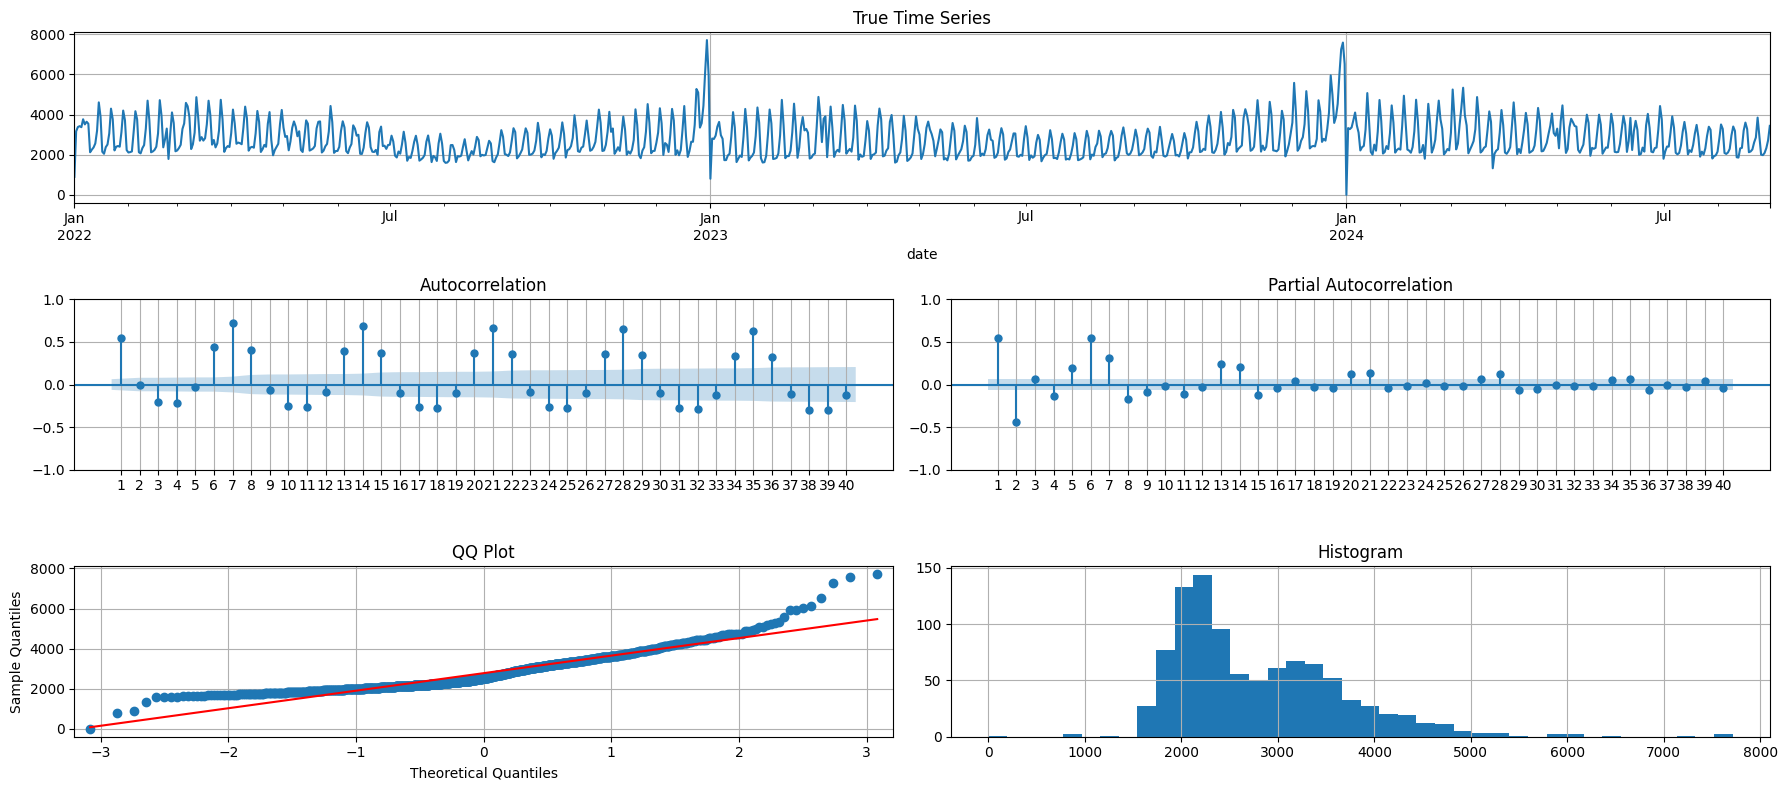

In [409]:
# применим функцию к первому временному ряду
print(f"Графики набора №1: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения")
tsdisplay(df1.value)

Мы видим по графику автокорреляции первого временного ряда максимальный лаг повторяется каждые 7 дней, т.е. текущее значение зависит от значения, которое получилось 7 дней (цикл 1 неделя), подходящий параметр q=7 (скользящее среднее).\
Максимальный лаг на частичной автокорреляции - 6, значит, порядок авторегрессии p=6, как вариант можно протестировать также 2, 7 лаги для сравнения.

Графики набора №2: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения


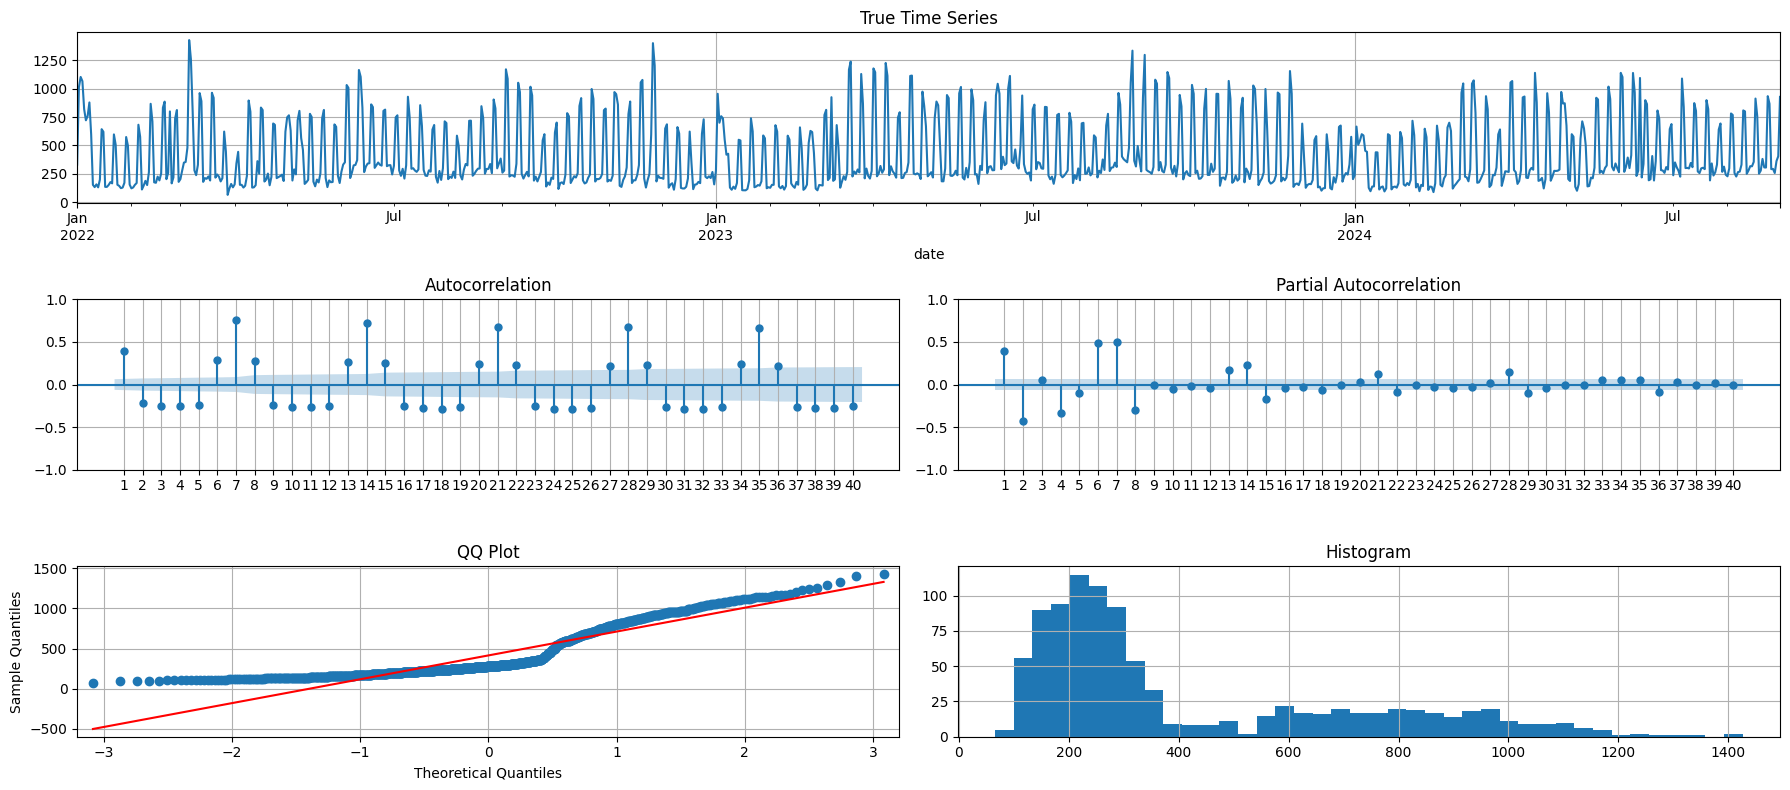

In [410]:
print(f"Графики набора №2: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения")
tsdisplay(df2.value)

Во втором ряду наблюдаем тот же цикл q=7 (максимальный лаг на автокорреляции), с запаздыванием у нас несколько вариантов получилось: 2, 6, 7, 8, какой из лагов окажется оптимальным, необходимо проверить в моделировании.

Графики набора №3: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения


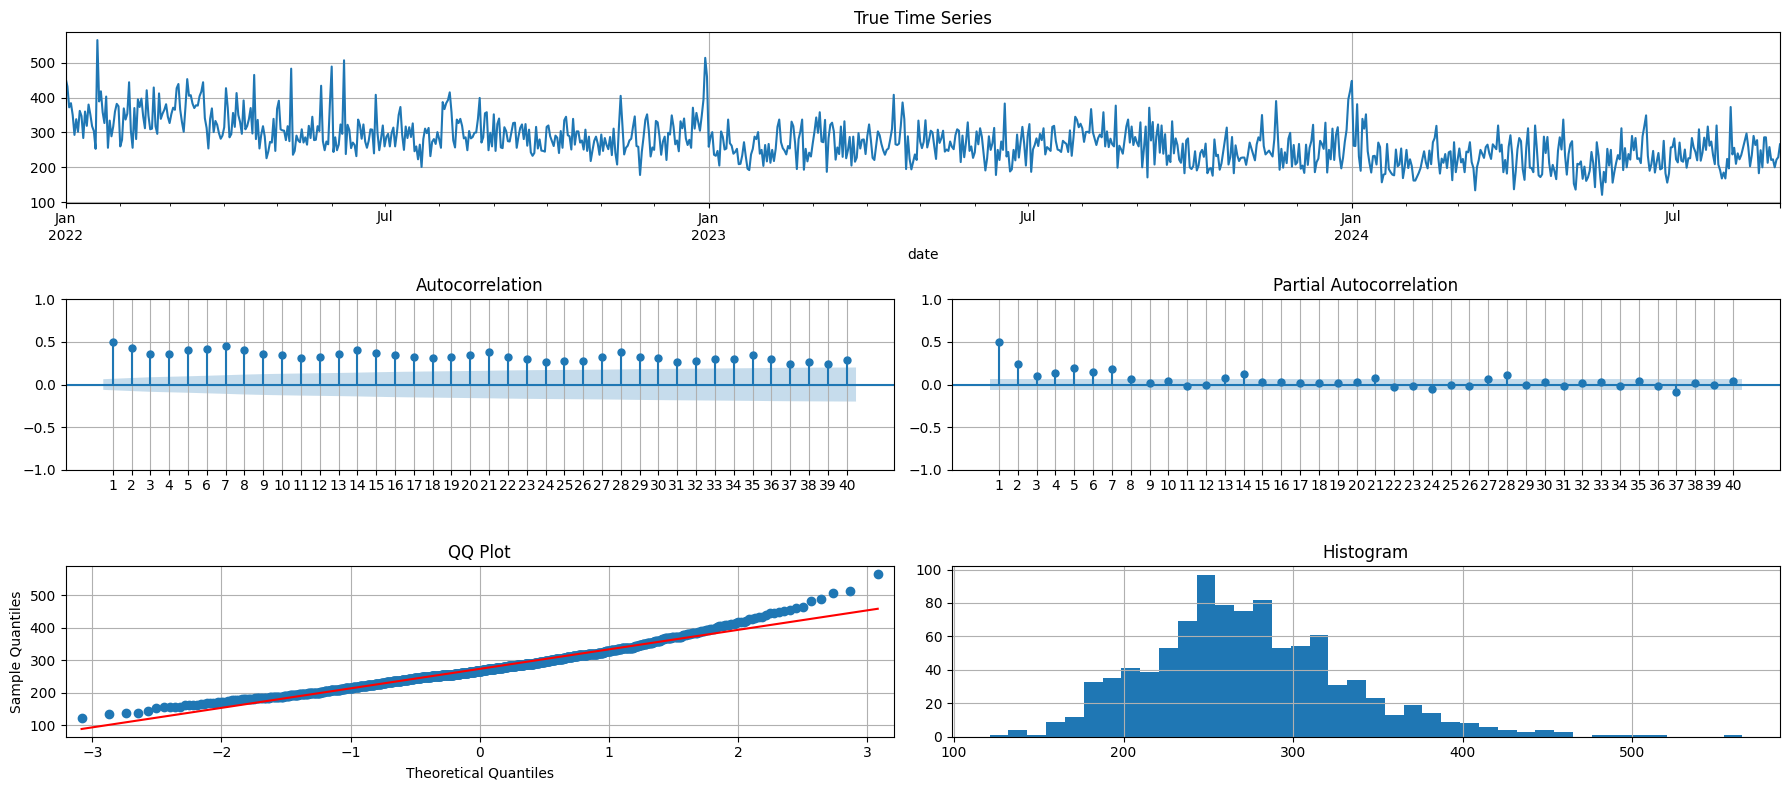

In [411]:
print(f"Графики набора №3: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения")
tsdisplay(df3.value)

Ряд №3: повторяющийся цикл автокорреляции, q=7, порядок авторегрессии проверим в нескольких значениях для сравнения: 2, 5, 7.

Графики набора №4: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения


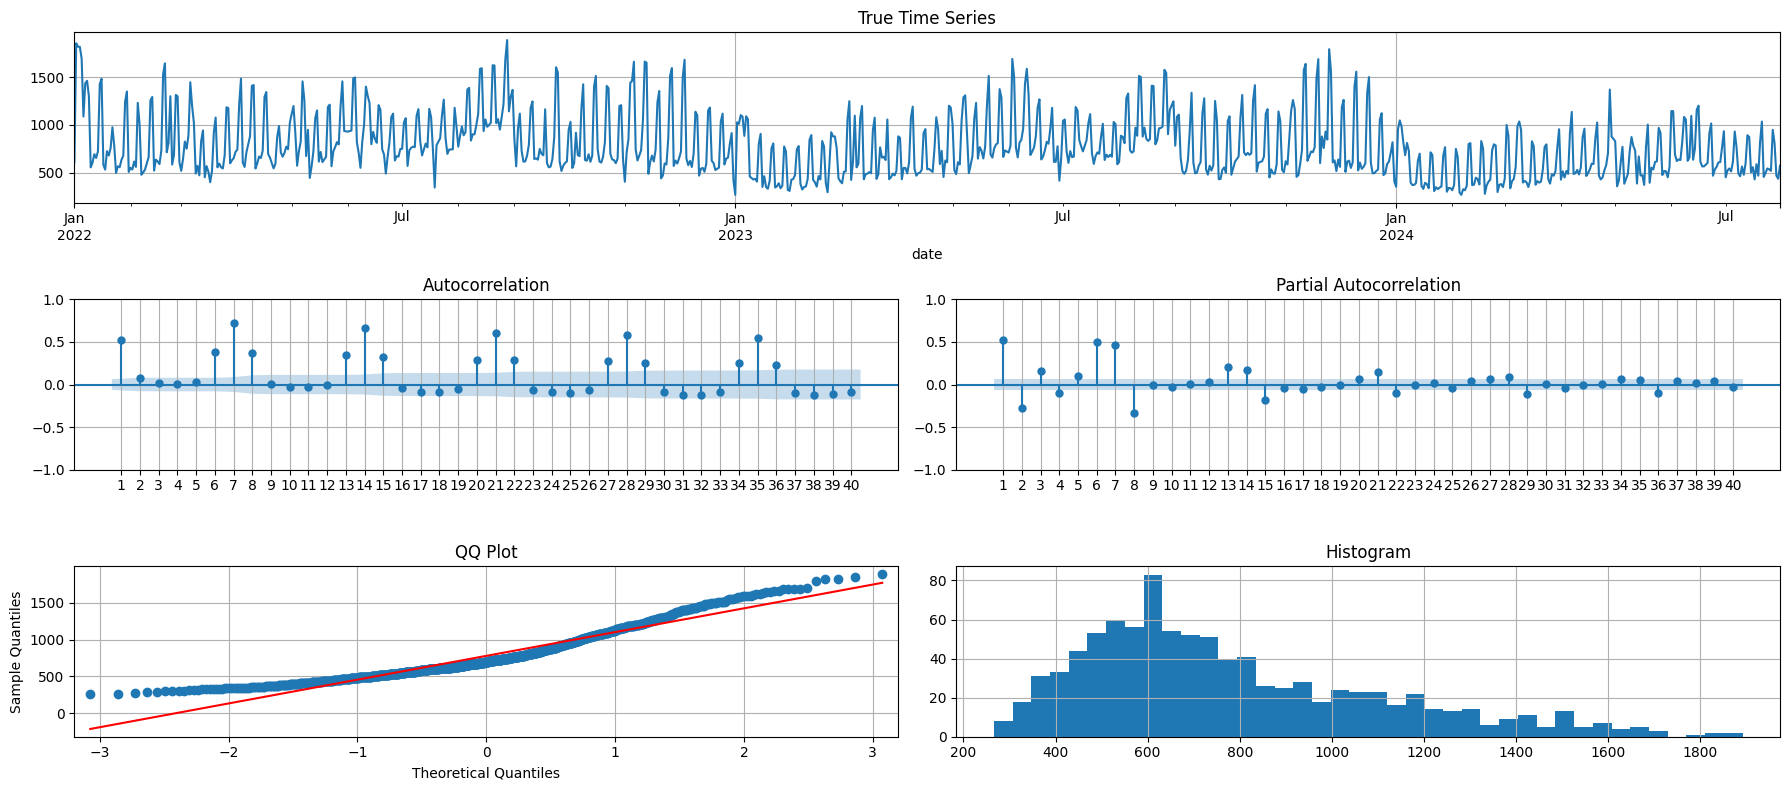

In [412]:
print(f"Графики набора №4: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения")
tsdisplay(df4.value)

По всем зависимостям 4-й ряд похож на 2-й временной ряд: q=7, p=[6,7,8], наиболее вероятные 6 или 7 как и во втором наборе данных.

Графики набора №5: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения


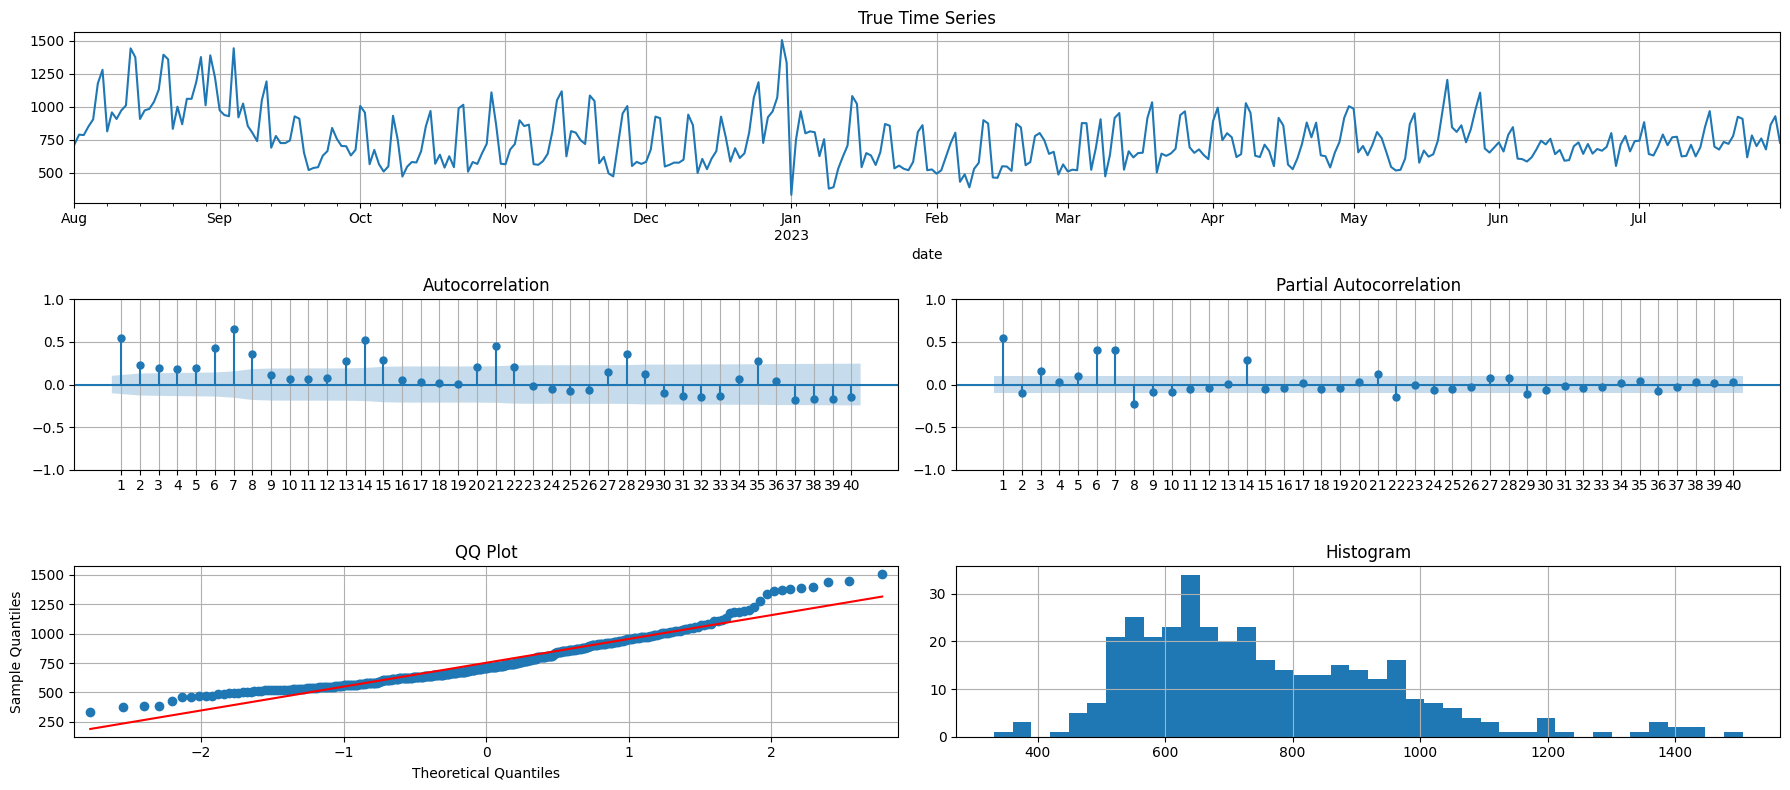

In [413]:
print(f"Графики набора №5: автокорреляция, частичная автокорреляция, QQ-график, гистограмма распределения")
tsdisplay(df5.value)

Хотя этот набор отличается небольших количеством данных, но мы видим тот же цикл в 7 дней (скользящее среднее q=7) и запаздывание в авторегрессии p = 6 или 7.

**3.3 Стационарность временных рядов**

Очень важным для прогнозирования является наличие стационарности у временного ряда, когда математическое ожидание, дисперсия и совместное распределение вероятности значений ряда не меняются при сдвиге во времени в отличие от изменения значений со временем.
Лишь стационарный процесс предсказуем. У стационарного ряда отсутствует тренд и сезонность.

Проведем тест на стационарность, применив тест Дики-Фуллера adfuller() из той же библиотеки statsmodels.
* Нулевая гипотеза $H_0$: временной ряд нестационарен, т.е. имеет некоторый тренд и сезонную компоненту. Значение статистики $p > \alpha$ - уровня значимости.
* Альтернатиная гипотеза $H_1$: временной ряд стационарен, не имеет тренда и сезонной компоненты, данные скорее случайны. Значение статистики $p < \alpha$ - уровня значимости.

Если тест подтвердит нестационарность (мы остановили выбор на пороге 0.01), то применим дифференцирование ряда - разность между двумя соседними наблюдениями. Дифференцирование мы будем повторять до тех пор пока ряд не приобретет стационарность. Весь этот процесс обернем в функцию.

In [414]:
# функция тестирования временного ряда на стационарность и дифференцирования его в случае нестационарности
def get_stationary(df):
    # создаем копию временного ряда, которую будем тестировать
    data = df['value'].copy()
    differenced = adfuller(data)                    # функция тестирования
    print('adf: ', differenced[0])                  # значение критерия теста
    print('p-value: ', differenced[1])              # значение p-value
    print('Critical values: ', differenced[4])      # пороговые значения доверительного интервала (0.01, 0.05, 0.1)
    count = 0                                       # переменная для подсчета порядка дифференцирования
    while differenced[0] > differenced[4]['5%']:
        print('Ряд нестационарен')
        data = data.diff().dropna()                   # дифференцируем с помощью функции diff() 
        differenced = adfuller(data)                  # вновь тестируем
        count += 1
    else:
        print('Ряд стационарен')
        print('-----------------------')
    return count, data

In [415]:
print("Тест Дики-Фулера на стационарность первого временного ряда")
# применим функцию преобразования ряда к стационарному для первого временного ряда
count, value_1 = get_stationary(df1)
# выведем порядок дифференцирования
print('Порядок интегрированного ряда: ', count)

Тест Дики-Фулера на стационарность первого временного ряда
adf:  -3.3317553865542338
p-value:  0.013517321859840106
Critical values:  {'1%': -3.4372303791313144, '5%': -2.864577551835195, '10%': -2.568387363624452}
Ряд стационарен
-----------------------
Порядок интегрированного ряда:  0


In [416]:
print("Тест Дики-Фулера на стационарность второго временного ряда")
# применим функцию преобразования ряда к стационарному для первого временного ряда
count, value_2 = get_stationary(df2)
# выведем порядок дифференцирования
print('Порядок интегрированного ряда: ', count)

Тест Дики-Фулера на стационарность второго временного ряда
adf:  -5.04260765378722
p-value:  1.8264323480495167e-05
Critical values:  {'1%': -3.437237626048241, '5%': -2.8645807475403657, '10%': -2.56838906578808}
Ряд стационарен
-----------------------
Порядок интегрированного ряда:  0


In [417]:
print("Тест Дики-Фулера на стационарность третьего временного ряда")
# применим функцию преобразования ряда к стационарному для первого временного ряда
count, value_3 = get_stationary(df3)
# выведем порядок дифференцирования
print('Порядок интегрированного ряда: ',count)

Тест Дики-Фулера на стационарность третьего временного ряда
adf:  -3.322793070847465
p-value:  0.013889862460178305
Critical values:  {'1%': -3.437180074590612, '5%': -2.8645553686071326, '10%': -2.5683755479600694}
Ряд стационарен
-----------------------
Порядок интегрированного ряда:  0


In [418]:
print("Тест Дики-Фулера на стационарность четвертого временного ряда")
# применим функцию преобразования ряда к стационарному для первого временного ряда
count, value_4 = get_stationary(df4)
# выведем порядок дифференцирования
print('Порядок интегрированного ряда: ',count)

Тест Дики-Фулера на стационарность четвертого временного ряда
adf:  -3.561718781412161
p-value:  0.0065364956835199635
Critical values:  {'1%': -3.437470108019385, '5%': -2.8646832620852853, '10%': -2.5684436698650503}
Ряд стационарен
-----------------------
Порядок интегрированного ряда:  0


In [419]:
print("Тест Дики-Фулера на стационарность первого временного ряда")
# применим функцию преобразования ряда к стационарному для первого временного ряда
count, value_5 = get_stationary(df5)
# выведем порядок дифференцирования
print('Порядок интегрированного ряда: ',count)

Тест Дики-Фулера на стационарность первого временного ряда
adf:  -2.9784610620164065
p-value:  0.03695541457928668
Critical values:  {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}
Ряд стационарен
-----------------------
Порядок интегрированного ряда:  0


Отличные новости: все наши ряды стационарны по 5%-порогу. 

### 3.4 Волатильность
Для любых данных, если в них есть волатильность, дисперсия будет непостоянной во времени и это уже влияет на построение прогноза.

Чтобы измерить как дисперсия изменяется во времени, мы воспользуемся методом из pandas pct_change(), который рассчитывает изменение на единицу измерения (относительное изменение). Умножим на 100, чтобы перевести в проценты.

In [420]:
def check_volatility(df):
    # вычисляем относительное изменение дисперсии
    df['value_vol'] = (df['value'].pct_change(1))*100
    # заполним образовавшийся пропуск первого значения
    df['value_vol'] = df['value_vol'].interpolate(method='bfill')
    return df

for df in dfs:
    check_volatility(df)

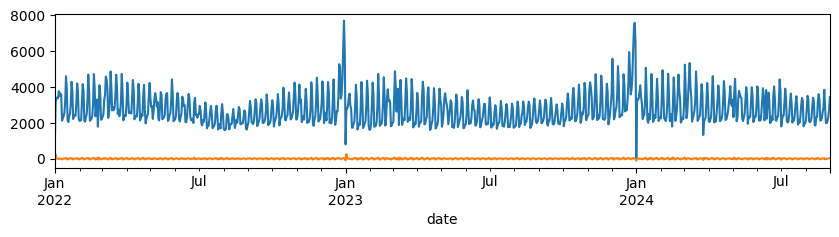

In [421]:
# функция для отображения волатильности
def visualise_volatility(df):
    df['value'].plot(figsize=(10,2))
    df['value_vol'].plot(figsize=(10,2));
    
visualise_volatility(df1)

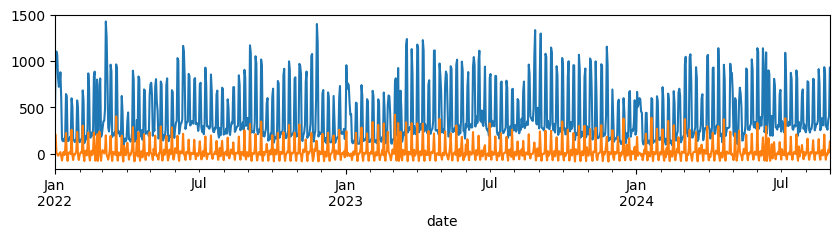

In [422]:
visualise_volatility(df2)

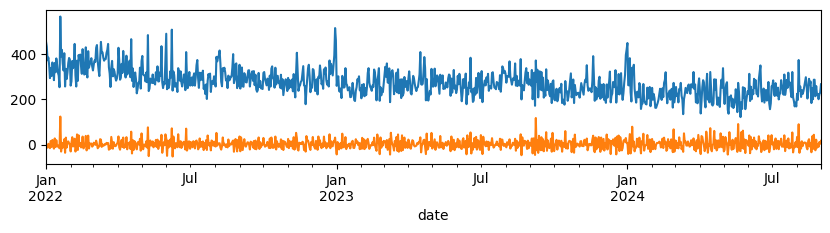

In [423]:
visualise_volatility(df3)

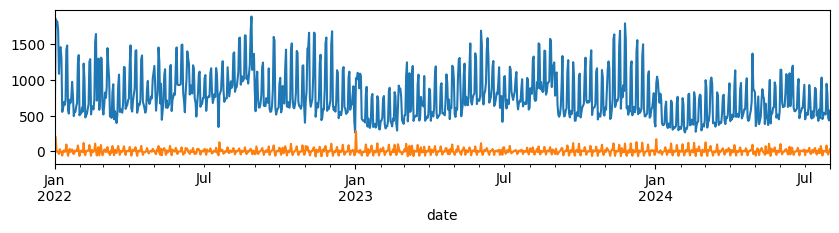

In [424]:
visualise_volatility(df4)

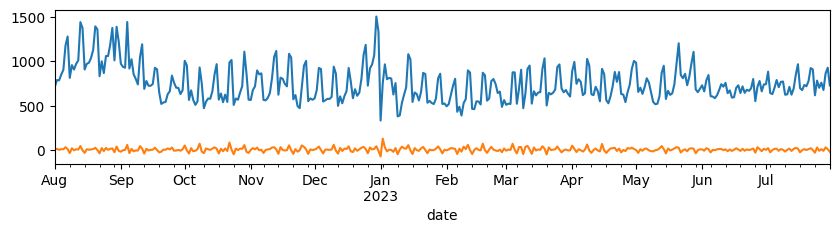

In [425]:
visualise_volatility(df5)

Второй и третий временные ряды немного подвержены волатильности.

В случае прогноза для них лучше использовать модель типа GARCH, которая является обобщенной авторегрессионной условной гетероскедастической моделью в отличие от гомоскедастической SARIMA с постоянной дисперсией во времени.

Мы попробуем перепрыгнуть этап построения простых моделей к наиболее популярной сейчас prophet, хотя предпочтительнее начать с более простого и в случае неудовлетворительного результата строить что-то более сложное и сравнивать.

### 4. Моделирование NeuralProphet
**4.1 Построение моделей**

По умолчанию объект NeuralProphet принимает два признака: даты, которые необходимо переименовать в столбец 'ds' и значения для предсказания с именем 'y'. Преобразовываем временные ряды в нужный формат для алгоритма.

In [426]:
# функция для создания нужного формата временного ряда
def rename_columns(df):
    train = pd.DataFrame({'ds': df.index, 'y': df['value']})
    return train

In [427]:
train_1 = rename_columns(df1)
train_2 = rename_columns(df2)
train_3 = rename_columns(df3)
train_4 = rename_columns(df4)
train_5 = rename_columns(df5)

In [428]:
# проверка
train_1.head()

,ds,y
date,,
2022-01-01,2022-01-01,898.0
2022-01-02,2022-01-02,3167.0
2022-01-03,2022-01-03,3380.0
2022-01-04,2022-01-04,3423.0
2022-01-05,2022-01-05,3373.0


In [429]:
def fit_model(train, n_lags=6, layers=8, rate=0.05):
    set_random_seed(seed=42)
    set_log_level("ERROR")
    # создаем экземпляр класса NeuralProphet
    prophet = NeuralProphet(
            growth='off',                          # тип роста тренда
            loss_func='MSE',                       # тип функции потерь
            yearly_seasonality=True,               # ежегодный характер сезонности
            weekly_seasonality=True,                     
            daily_seasonality='auto',              
            learning_rate=rate,                    # темп обучения                  
            epochs=100,                            # количество итераций
            future_regressors_model='neural_nets',
            future_regressors_d_hidden=layers,     # количество внутренних слоев нейросети
            n_lags=n_lags,                         # порядок авторегрессии
            n_forecasts=1,
            collect_metrics=["RMSE", "MAE"]        # параметры для вычислений   
    )
    prophet.set_plotting_backend("plotly")
    # используем функцию этой же библиотеки для разделения данных на тренировочную и тестовую выборки
    train, test = prophet.split_df(train, freq='D', valid_p = 0.15)
    # обучаем тестовый набор, добавим ранюю остановку, если далее снижение функции потерь не происходит
    # и обозначим время старта обучения
    start_time = time.time()
    metrics_train = prophet.fit(train, freq='D', validation_df=test, metrics=True, early_stopping=True)
    metrics_test = prophet.test(test)
    predictions = prophet.predict(test)
    exec_time = time.time() - start_time
    
    return metrics_train, metrics_test, prophet, predictions, exec_time 

Сначала в цикле для каждого временного ряда определим оптимальный порядок авторегрессии - lag.

Запускайте ячейки, если хочется посмотреть на различные выводы метрик качества в зависимости от порядка авторегрессии. Они закомментированы, чтобы не отнимать ваше время на перебор. В данном случае, мы не стали использовать инструменты типа optuna, hyperopt, т.к. проверяем лишь один параметр, но можно уделить время и другим гиперпараметрам, вроде шага обучения, нейрослоев, эпох и т.п., тогда лучше использовать готовый пакет, а не вложенные циклы.

In [430]:
lags = list(range(1,9))
# print('Fitting of time serie №1')
# for i, lag in enumerate(lags):
#     metrics_train_1, metrics_valid_1, model_1, predictions_1, exec_time_1 = fit_model(train_1, n_lags=lag)
#     print('Iteration: ', i+1, metrics_valid_1['RMSE_val'][0])

In [431]:
# print('Fitting of time serie №2')
# for i, lag in enumerate(lags):
#     metrics_train_2, metrics_valid_2, model_2, predictions_2, exec_time_2 = fit_model(train_2, n_lags=lag)
#     print('Iteration: ', i+1, metrics_valid_2['RMSE_val'][0])

In [432]:
# print('Fitting of time serie №3')
# for i, lag in enumerate(lags):
#     metrics_train_3, metrics_valid_3, model_3, predictions_3, exec_time_3 = fit_model(train_3, n_lags=lag)
#     print('Iteration: ', i+1, metrics_valid_3['RMSE_val'][0])

In [433]:
# print('Fitting of time serie №4')
# for i, lag in enumerate(lags):
#     metrics_train_4, metrics_valid_4, model_4, predictions_4, exec_time_4 = fit_model(train_4, n_lags=lag)
#     print('Iteration: ', i+1, metrics_valid_4['RMSE_val'][0])

In [434]:
# print('Fitting pf time serie №5')
# for i, lag in enumerate(lags):
#     metrics_train_5, metrics_valid_5, model_5, predictions_5, exec_time_5 = fit_model(train_5, n_lags=lag)
#     print('Iteration: ', i+1, metrics_valid_5['RMSE_val'][0])

Итак, мы определили порядок авторегрессии для каждого ряда и приступим к обучению и предсказанию на валидационной выборке в соотношении 85/15.

In [435]:
metrics_train_1, metrics_valid_1, model_1, predictions_1, exec_time_1 = fit_model(train_1)
metrics_train_2, metrics_valid_2, model_2, predictions_2, exec_time_2 = fit_model(train_2, layers=12)
metrics_train_3, metrics_valid_3, model_3, predictions_3, exec_time_3 = fit_model(train_3, n_lags=5, layers=10)
metrics_train_4, metrics_valid_4, model_4, predictions_4, exec_time_4 = fit_model(train_4, layers=10, rate=0.06)
metrics_train_5, metrics_valid_5, model_5, predictions_5, exec_time_5 = fit_model(train_5, n_lags=7, layers=5, rate=0.06)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.004895071964710951    │
│          MAE_val          │    221.36448669433594     │
│         RMSE_val          │     310.3078308105469     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.022742269560694695    │
│          MAE_val          │     90.55602264404297     │
│         RMSE_val          │     143.1444854736328     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.031488023698329926    │
│          MAE_val          │    37.472816467285156     │
│         RMSE_val          │    45.107444763183594     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.013667935505509377    │
│          MAE_val          │    106.45772552490234     │
│         RMSE_val          │      142.7294921875       │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.02105296030640602    │
│          MAE_val          │     96.4572525024414      │
│         RMSE_val          │    119.00080108642578     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

In [436]:
# отобразим время и значение RMSE на отложенной выборке в таблице
results = pd.DataFrame({
    'time series': ['set_1', 'set_2', 'set_3', 'set_4', 'set_5'],
    'valid_RMSE': [metrics_valid_1['RMSE_val'][0], metrics_valid_2['RMSE_val'][0], metrics_valid_3['RMSE_val'][0], metrics_valid_4['RMSE_val'][0], metrics_valid_5['RMSE_val'][0]],
    'exec_time': [exec_time_1, exec_time_2, exec_time_3, exec_time_4, exec_time_5]
    })
results.style.format(precision=2)

,time series,valid_RMSE,exec_time
0,set_1,310.31,17.82
1,set_2,143.14,30.45
2,set_3,45.11,22.92
3,set_4,142.73,18.63
4,set_5,119.00,8.88


In [437]:
print('Общее время обучения всех моделей и создания прогноза на валидационных наборах (сек.): ', results['exec_time'].sum().round(1))

Общее время обучения всех моделей и создания прогноза на валидационных наборах (сек.):  98.7


In [438]:
print('Абсолютная средняя ошибка в процентах по каждому ряду: ')
print('MAPE_1: {}%'.format(np.round(mape(predictions_1['y'].iloc[6:], predictions_1['yhat1'].iloc[6:])*100,3)))
print('MAPE_2: {}%'.format(np.round(mape(predictions_2['y'].iloc[6:], predictions_2['yhat1'].iloc[6:])*100,3)))
print('MAPE_3: {}%'.format(np.round(mape(predictions_3['y'].iloc[5:], predictions_3['yhat1'].iloc[5:])*100,3)))
print('MAPE_4: {}%'.format(np.round(mape(predictions_4['y'].iloc[6:], predictions_4['yhat1'].iloc[6:])*100,3)))
print('MAPE_5: {}%'.format(np.round(mape(predictions_5['y'].iloc[7:], predictions_5['yhat1'].iloc[7:])*100,3)))

Абсолютная средняя ошибка в процентах по каждому ряду: 
MAPE_1: 7.833%
MAPE_2: 24.138%
MAPE_3: 17.623%
MAPE_4: 17.391%
MAPE_5: 13.361%


**4.2 Создание прогнозов по каждому ряду**

Напишем функцию для предсказания значений на следующий месяц, в качестве обучения в этом случае мы используем весь набор, чтобы модель обладала большей информативностью.\
Функция принимает датасет, модель и n - число дней, которое мы хотим предсказать:
* В предсказание используется принцип скользящего среднего. Мы предсказываем на один шаг (один день), добавляем это значение в исторические данные и вновь предсказываем на шаг вперед.
* Функция возвращает датасет forecast с историческими истинными значениями и предсказанными, который мы визуализируем. А также время, затраченное на прогноз.

In [439]:
def make_prediction(data, model, n):
    for i in range(n):
        start_time = time.time()
        future_df = model.make_future_dataframe(data, periods=31, n_historic_predictions=len(data))
        forecast = model.predict(future_df)
        # создаем датафрейм с датами следующего календарного месяца и пустыми значениями, которые будем предсказывать
        period = pd.DataFrame(data={"ds": pd.date_range(start=data["ds"].tail(1).values[0], periods=2, freq="D"), "y": np.NaN})
        data = pd.concat([data, period], axis=0).drop_duplicates(subset='ds').reset_index().drop('index', axis=1)
        data['y'].iloc[-1] = forecast['yhat1'].iloc[-1]
        exec_time = time.time() - start_time
    return forecast, exec_time

In [440]:
forecast_1, pred_time_1 = make_prediction(train_1, model_1, n=30) # предсказываем сентябрь для первого набора
forecast_2, pred_time_2 = make_prediction(train_2, model_2, n=30) # предсказываем сентябрь для второго набора
forecast_3, pred_time_3 = make_prediction(train_3, model_3, n=30) # предсказываем сентябрь для третьего набора
forecast_4, pred_time_4 = make_prediction(train_4, model_4, n=31) # предсказываем августа для четвертого набора
forecast_5, pred_time_5 = make_prediction(train_5, model_5, n=31) # предсказываем августа для пятого набора


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [441]:
# сложим время на обучение модели и формирование прогноза
exet_time = pd.DataFrame({
    'time series': ['set_1', 'set_2', 'set_3', 'set_4', 'set_5'],
    'exec_time_totally': [exec_time_1+pred_time_1, exec_time_2+pred_time_2, exec_time_3+pred_time_3, exec_time_4+pred_time_4, exec_time_5+pred_time_5]
    })
exet_time.style.format(precision=2)

,time series,exec_time_totally
0,set_1,17.96
1,set_2,30.58
2,set_3,23.05
3,set_4,18.75
4,set_5,9.05


In [442]:
# суммируем затраченное на весь процесс время
print("Общее время в минутах: ", np.round(exet_time['exec_time_totally'].sum()/60, 2))

Общее время в минутах:  1.66


**4.3 Визуализация предсказанных значений по каждому временному ряду и сохранение данных**

In [443]:
# делаем стыковку по индексу
def make_forecast(forecast, train):
    idx = forecast[forecast['ds']==train['ds'].iloc[-1]].index[0]
    forecast['y'].iloc[idx+1:] = np.NaN
    return forecast

forecasts = [forecast_1, forecast_2, forecast_3, forecast_4, forecast_5]  
trains = [train_1, train_2, train_3, train_4, train_5] 
for forecast, train in list(zip(forecasts,trains)):
    make_forecast(forecast, train) 

In [444]:
models = [model_1, model_2, model_3, model_4, model_5]
# визуализируем предсказания инструментами prophet
for model, forecast in list(zip(models, forecasts)):
    display(model.plot(forecast, figsize=(15,5), plotting_backend='plotly'))

Все наши наборы имеют сезонные (циклические) компоненты и мы можем благодаря инструментам prophet посмотреть их в каждом ряду.
Данные графики очень удобны в еженедельных планированиях компании, чтобы более разумно использовать ресурсы.

In [445]:
fig = model_1.plot_parameters(figsize=(8,1.5), plotting_backend='plotly')
fig.write_image('images/Seasonality Set №1.png')
fig

In [446]:
fig = model_2.plot_parameters(figsize=(8,1.5), plotting_backend='plotly')
fig.write_image('images/Seasonality Set №2.png')
fig

In [447]:
fig = model_3.plot_parameters(figsize=(8,1.5), plotting_backend='plotly')
fig.write_image('images/Seasonality Set №3.png')
fig

In [448]:
fig = model_4.plot_parameters(figsize=(8,1.5), plotting_backend='plotly')
fig.write_image('images/Seasonality Set №4.png')
fig

In [449]:
fig = model_5.plot_parameters(figsize=(8,1.5), plotting_backend='plotly')
fig.write_image('images/Seasonality Set №5.png')
fig

In [450]:
# функция для визуализации графика предсказаний
def save_forecast(train, prediction, forecast, title=" "):
    for i in range(1, 5):
        fig = go.Figure()
        # исходные данные
        fig.add_trace(go.Scatter(x=train.ds.iloc[700:], y=train.y.iloc[700:], name='True Value', line=dict(color='green', width=2)))
        # предсказанные значения на валидационной выборке
        fig.add_trace(go.Scatter(x=prediction.ds, y=prediction.yhat1, name='Predicted Valid', line=dict(color='blue', width=2)))
        # прогноз на будущее
        fig.add_trace(go.Scatter(x=forecast.ds.iloc[700:], y=forecast.yhat1.iloc[700:], name='Forecast', line=dict(color='magenta', width=1.5)))
        fig.update_layout(
            title={'text': title,'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, 
            width=900, height=250,
            autosize=False, margin=dict(t=30, b=60, l=30, r=10),
            template="plotly",
            legend=dict(yanchor="bottom", y=-0.2, orientation='h', xanchor="right", x=0.9)
        )
    fig.write_image(f'images/{title}.png')
    fig.show()

In [451]:
save_forecast(train_1, predictions_1, forecast_1, title='Forecast set 1')
save_forecast(train_2, predictions_2, forecast_2, title='Forecast set 2')
save_forecast(train_3, predictions_3, forecast_3, title='Forecast set 3')
save_forecast(train_4, predictions_4, forecast_4, title='Forecast set 4')

In [452]:
# график прогноза для пятого временного ряда
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_5.ds.iloc[300:], y=train_5.y.iloc[300:], name='True Value', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=predictions_5.ds, y=predictions_5.yhat1, name='Predicted Valid', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=forecast_5.ds.iloc[300:], y=forecast_5.yhat1.iloc[300:], name='Forecast', line=dict(color='magenta', width=1.5)))

fig.update_layout(
    title={'text': f'Forecast set 5','x':0.5,'xanchor': 'center', 'yanchor': 'top'}, 
    width=900, height=250,
    autosize=False, margin=dict(t=30, b=60, l=30, r=10),
    template="plotly",
    legend=dict(yanchor="bottom", y=-0.2, orientation='h', xanchor="right", x=0.9)
    )
fig.write_image(f'images/Forecast set 5.png')
fig.show()

In [453]:
forecast_1.tail()

,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
999,2024-09-26,NaN,2004.523315,-0.166492,2753.219238,-392.785889,-355.743622
1000,2024-09-27,NaN,2753.588623,-0.120608,2753.219238,-375.682739,376.172668
1001,2024-09-28,NaN,3616.208496,-0.082052,2753.219238,-356.785431,1219.856567
1002,2024-09-29,NaN,2998.875977,-0.060438,2753.219238,-336.134003,581.851196
1003,2024-09-30,NaN,1736.118042,-0.053729,2753.219238,-313.922180,-703.125305


Оформим прогнозы по каждому ряду в тот же формат, как исходные, и сохраним их.

In [454]:
def make_submission(forecast, n):
    submission = pd.DataFrame({'value': forecast['yhat1'].iloc[-n:], 'date': forecast['ds'].iloc[-n:]}).reset_index().drop('index', axis=1)
    return submission

In [455]:
submission_1 = make_submission(forecast_1, n=30)
submission_1.to_csv('data/submissions_data1.csv', index=False)
submission_2 = make_submission(forecast_2, n=30)
submission_2.to_csv('data/submissions_data2.csv', index=False)
submission_3 = make_submission(forecast_3, n=30)
submission_3.to_csv('data/submissions_data3.csv', index=False)
submission_4 = make_submission(forecast_4, n=31)
submission_4.to_csv('data/submissions_data4.csv', index=False)
submission_5 = make_submission(forecast_5, n=31)
submission_5.to_csv('data/submissions_data5.csv', index=False)

In [456]:
submission_1.head()

,value,date
0,2957.933838,2024-09-01
1,1727.620239,2024-09-02
2,1825.530762,2024-09-03
3,1915.142212,2024-09-04
4,2032.660522,2024-09-05


### Заключение
1. Мы изучили наши данные и отразили важные зависимости в них: циклы, периодичности, зависимости от наблюдений.
2. Для каждого ряда мы обучали новую модель, а предсказания делали последовательно по типу скользящего среднего с одним смещением.
3. Общее время на обучение прекрасно: 2 мин на все обучение и все прогнозы.
4. Да, мы пошли коротким путем, обратились к нейроалгоритму, это quick-decision, модель относительно справилась с задачей: уловила некоторые закономерности, цикличность, но не все: редкие аномальные значения пропущены моделью.
5. Нейросети любят большие данные и если модель будет работать при постоянной подгрузке к ней новых данных, то ее прогноз со временем улучшится. 
6. Можно добавить слоев, если, конечно, будет больше данных, на таком небольшом объеме существует рист переобучения.

In [457]:
# !pip freeze > requirements.txt